In [113]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import math
import numpy as np
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm, trange
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.path import Path
from matplotlib.patches import Rectangle, PathPatch
from tensorflow import keras as K
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import random

# sys.path.append('../../SketchRNN_tf2')
from sketchrnn_ouatai import models, dataset, utils

sns.set('notebook', 'whitegrid', rc=utils.mpl_rc())

print("tf: {}".format(tf.version.VERSION))
print("tf.keras: {}".format(K.__version__))

tf: 2.5.1
tf.keras: 2.5.0


In [2]:
import random
from PIL import Image
import io
import pandas as pd

In [3]:
!pwd
!ls ../../raw_data/models/

/home/romain/code/Tchook115/ouatai/notebooks
models_sketch_rnn_ant_weights.100.hdf5
models_sketch_rnn_basket_weights.200.hdf5
models_sketch_rnn_bulldozer_weights.100.hdf5
sketch_rnn_cat_weights.78_0.01.hdf5
sketch_rnn_rabbit_weights.100_0.06.hdf5


## dessine moi un objet

In [4]:
best_images = {
    'bulldozer': np.load('/home/romain/code/Tchook115/raw_data/best_bulldozer_100_epochs.npy', allow_pickle=True),
    'rabbit' : np.load('/home/romain/code/Tchook115/raw_data/best_rabbit.npy', allow_pickle=True), 
    'cat' : np.load('/home/romain/code/Tchook115/raw_data/best_cat.npy', allow_pickle=True),
    'ant' : np.load('/home/romain/code/Tchook115/raw_data/best_ant.npy', allow_pickle=True),
    'basket' : np.load('/home/romain/code/Tchook115/raw_data/best_basket.npy', allow_pickle=True)
}
fichiers = {
        'bulldozer': 'models_sketch_rnn_bulldozer_weights.100.hdf5', 
        'cat' : 'sketch_rnn_cat_weights.78_0.01.hdf5',
        'rabbit' : 'sketch_rnn_rabbit_weights.100_0.06.hdf5',
        'ant' : ' models_sketch_rnn_ant_weights.100.hdf5',
        'basket' : 'models_sketch_rnn_basket_weights.200.hdf5'
               }
words = ['bulldozer', 'cat', 'rabbit', 'ant', 'basket']

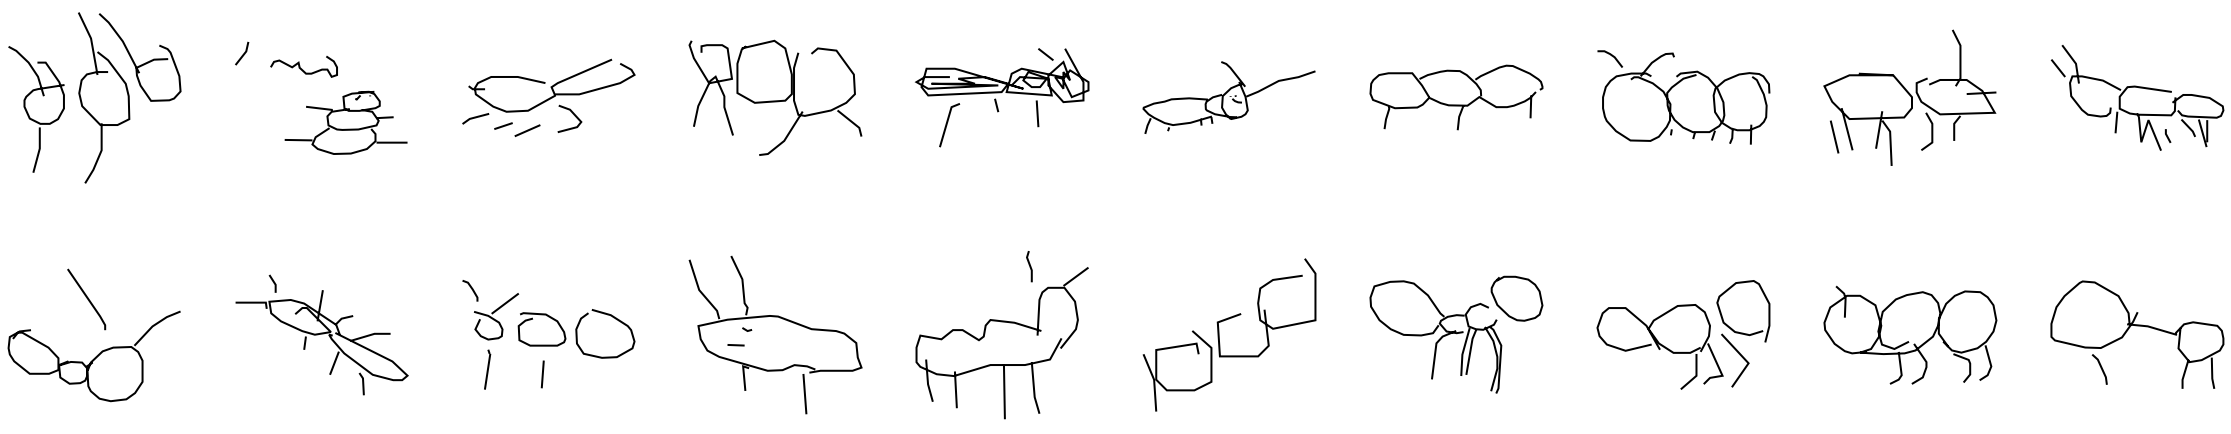

In [136]:
word = 'ant'
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for index, ax in enumerate(axs[0]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[word][index]))
for index, ax in enumerate(axs[1]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[word][index+10]))

In [139]:
def dessine_moi_un(word, temperature = 0.3, color = 'black', zoom = 1):
    
    if word not in words:
        return 'essaie un autre mot stp'
    
    #test de variables random
    max_seq_len = best_images[word][0].shape[0]-1
    data_train = [1 for k in range(10000)]
    
    hps = {
        "max_seq_len": max_seq_len,
        'batch_size': 100,
        "num_batches": math.ceil(len(data_train) / 100),
        "epochs": 1,
        "recurrent_dropout_prob": 0.1,
        "enc_rnn_size": 256,
        "dec_rnn_size": 512,
        "z_size": 128,
        "num_mixture": 20,
        "learning_rate": 0.001,
        "min_learning_rate": 0.00001,
        "decay_rate": 0.9999,
        "grad_clip": 1.0,
        'kl_tolerance': 0.2,
        'kl_decay_rate': 0.99995,
        "kl_weight": 0.5,
        'kl_weight_start': 0.01,
    }
    
    # load model
    sketchrnn = models.SketchRNN(hps)
    initial_epoch, initial_loss = 100, 0.06
    
    checkpoint = os.path.join('../../raw_data/models/', fichiers[word])
    sketchrnn.load_weights(checkpoint)
    
    # building image 
    best_pic = random.choice(best_images[word])
    d = np.expand_dims(best_pic,0)
    z = sketchrnn.models['encoder'].predict(d[:,1:])[0]
    strokes = sketchrnn.sample(z=z, temperature=temperature)
    
    final_object = utils.to_normal_strokes(strokes)
    figheight = 3*zoom
    figwidth = 3*zoom
    figsize = (figheight,figwidth)
    fig, ax = plt.subplots(figsize=figsize)
    utils.plot_strokes(ax, final_object, ec = color)
    
    # figure to PIL image
    buf = io.BytesIO()
    fig.savefig(buf, format='png',pad_inches=0,transparent=True)
    buf.seek(0)
    image = Image.open(buf)
    image = image.copy()
    buf.close()
    return image

Loaded Weights From: ../../raw_data/models/models_sketch_rnn_basket_weights.200.hdf5


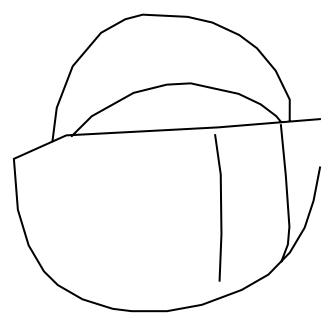

In [140]:
image = dessine_moi_un('basket')

In [82]:
type(image)

PIL.Image.Image

Loaded Weights From: ../../raw_data/models/models_sketch_rnn_basket_weights.200.hdf5
Loaded Weights From: ../../raw_data/models/models_sketch_rnn_basket_weights.200.hdf5
Loaded Weights From: ../../raw_data/models/models_sketch_rnn_basket_weights.200.hdf5
Loaded Weights From: ../../raw_data/models/models_sketch_rnn_basket_weights.200.hdf5
Loaded Weights From: ../../raw_data/models/models_sketch_rnn_basket_weights.200.hdf5


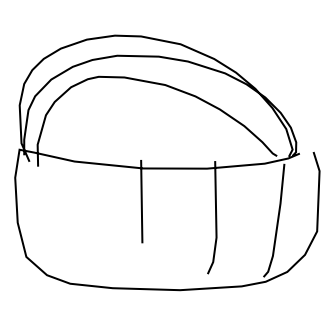

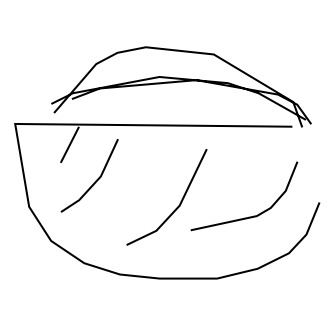

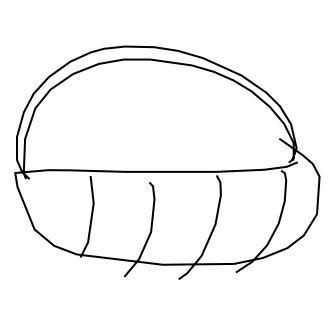

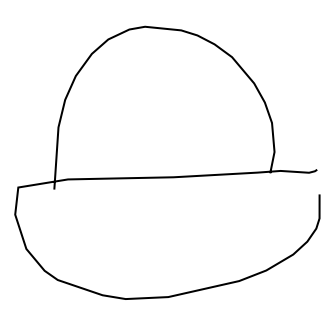

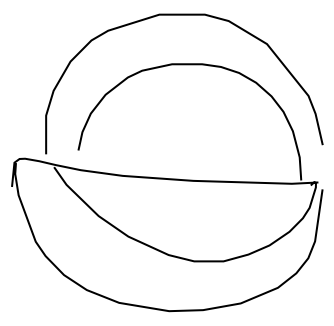

In [83]:
for k in range(5):
    dessine_moi_un('basket')

Loaded Weights From: ../../raw_data/models/models_sketch_rnn_bulldozer_weights.100.hdf5


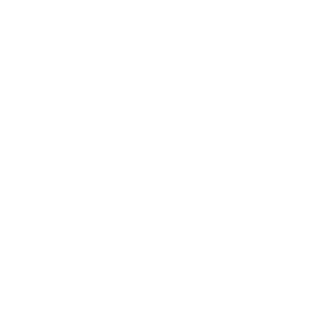

In [8]:
bulldozer = dessine_moi_un('bulldozer', color = 'green', zoom = 1)

In [9]:
type(bulldozer)

PIL.Image.Image

## la scene

In [89]:
scene_size = (2_000, 1_000)

In [203]:
def construis_la_scene(list_objects, scene_size = scene_size):
    '''
    list_objects = [[img_obj1, position_obj1], ...]
    '''
    scene = Image.new('RGBA', scene_size)
    for obj in list_objects:
        scene.paste(obj[0], obj[1])
        #scene = Image.alpha_composite(scene, obj[0])
    return scene

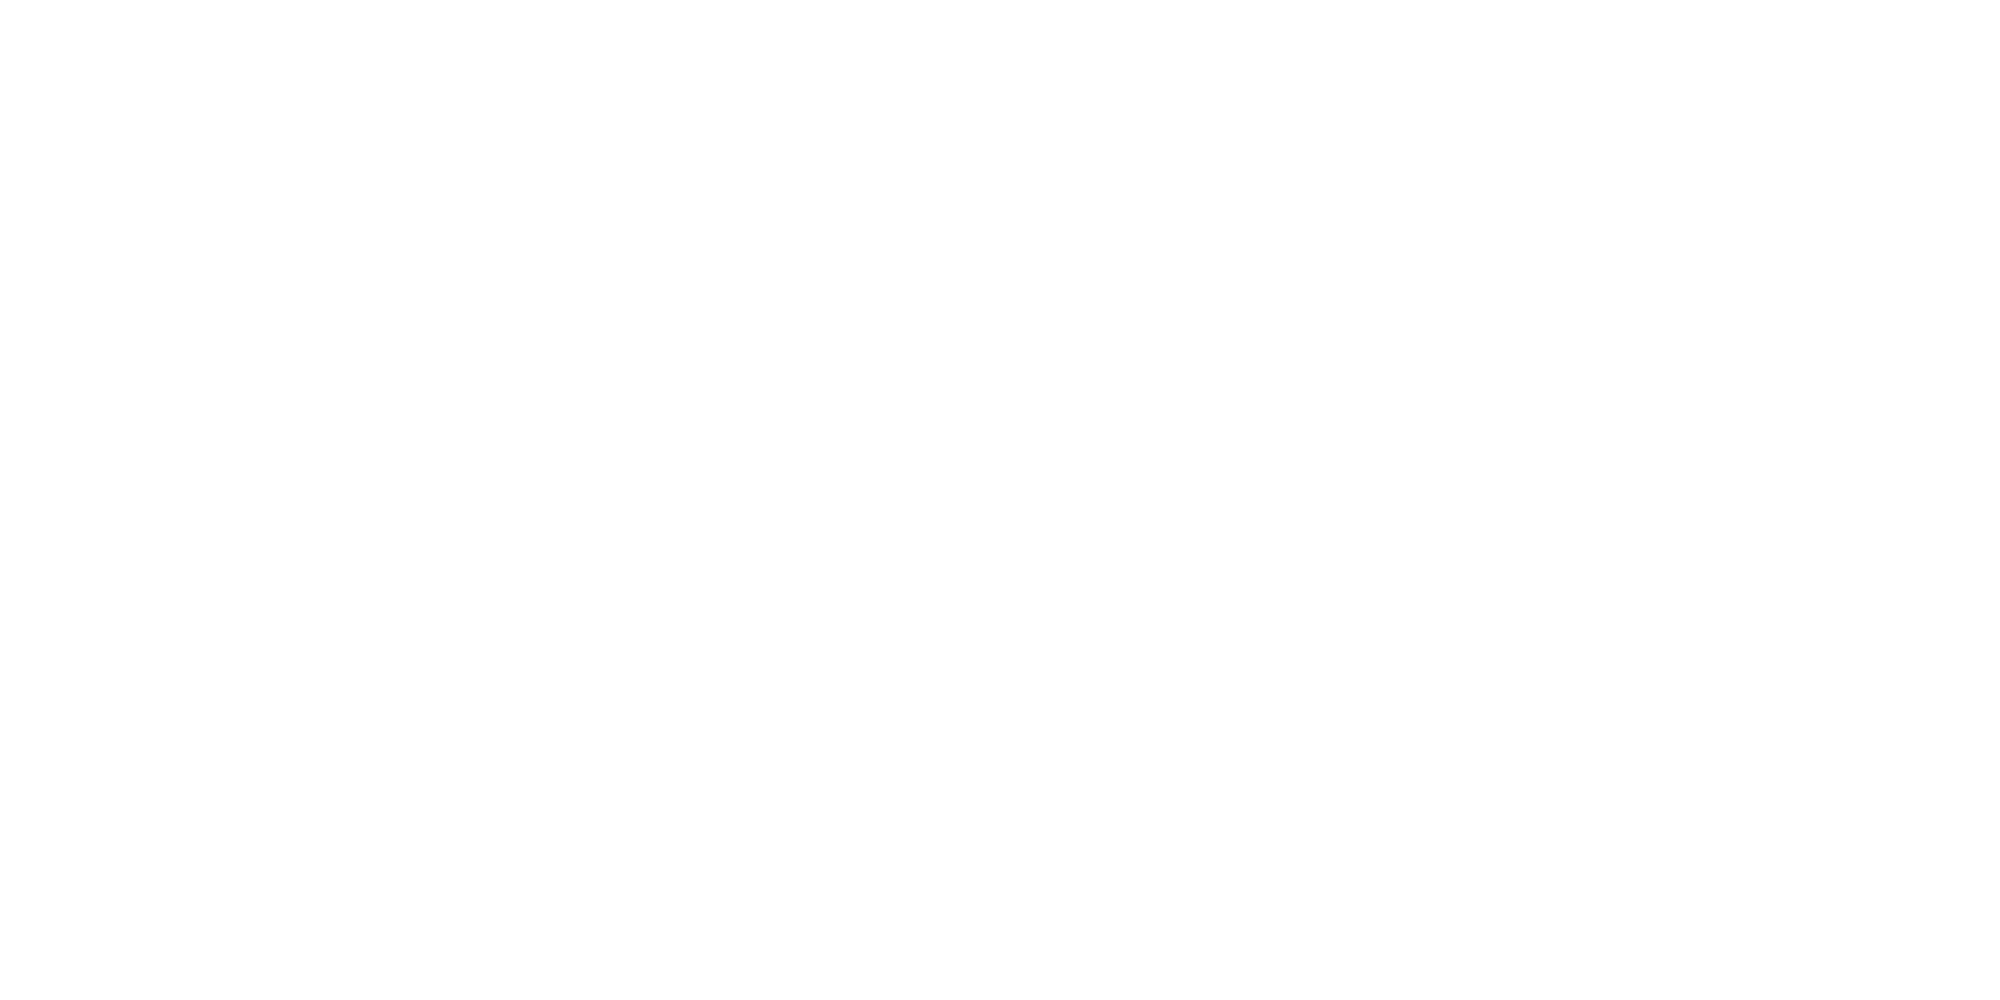

In [204]:

construis_la_scene([])

In [206]:
df = pd.DataFrame(np.array([['cat', 'blue', 'small', 3, 'centre', 'middle'],
                             ['bulldozer', 'orange', 'small', 2, 'bottom', 'right'], 
                             ['rabbit', 'brown', 'small', 3, 'top', 'left'],
                            ]),
                   columns=['category', 'color', 'size', 'num', 'vertical_position', 'horizontal_position'])
df

,category,color,size,num,vertical_position,horizontal_position
0,cat,blue,small,3,centre,middle
1,bulldozer,orange,small,2,bottom,right
2,rabbit,brown,small,3,top,left


In [207]:
from PIL import ImageDraw

In [208]:
def df_to_scene(df, scene_size = scene_size):
    list_objects = []
    list_position = []
    vertical_positions = {
        'top' : 0,
        'centre' : int(scene_size[1]/3),
        'bottom' : int(2*scene_size[1]/3)
    }
    horizontal_positions = {
        'left' : 0,
        'middle' : int(scene_size[0]/3),
        'right' : int(2*scene_size[0]/3)
    }
    sizes = {
        'small' : 1/2,
        'medium' : 1,
        'big' : 2
    }
    for index, row in df.iterrows():
        print(f'{index},{row}')
        print
        for n in range(int(row['num'])):            
            category = row['category']
            color = row['color']
            size = sizes[row['size']]
            image = dessine_moi_un(category, color = color, zoom = size)
            imgwidth, imgheight = image.size
            #position
            starthoriz = horizontal_positions[row['horizontal_position']]
            stophoriz = starthoriz + (horizontal_positions['middle'] - imgwidth)
            startvert = vertical_positions[row['vertical_position']]
            stopvert = startvert + (vertical_positions['centre'] - imgheight)
            hor = random.randint(starthoriz,stophoriz)
            vert = random.randint(startvert,stopvert)
            
            list_objects.append([image, (hor, vert)])
    scene = construis_la_scene(list_objects, scene_size)
    #Les traits noirs
    draw = ImageDraw.Draw(scene)
    for h in range(scene_size[0]):
        draw.point((h,vertical_positions['centre']), fill="black")
    for h in range(scene_size[0]):
        draw.point((h,vertical_positions['bottom']), fill="black")
    for v in range(scene_size[1]):
        draw.point((horizontal_positions['middle'], v), fill="black")
    for v in range(scene_size[1]):
        draw.point((horizontal_positions['right'], v), fill="black")
    return scene

0,category                  cat
color                    blue
size                    small
num                         3
vertical_position      centre
horizontal_position    middle
Name: 0, dtype: object
Loaded Weights From: ../../raw_data/models/sketch_rnn_cat_weights.78_0.01.hdf5
Loaded Weights From: ../../raw_data/models/sketch_rnn_cat_weights.78_0.01.hdf5
Loaded Weights From: ../../raw_data/models/sketch_rnn_cat_weights.78_0.01.hdf5
1,category               bulldozer
color                     orange
size                       small
num                            2
vertical_position         bottom
horizontal_position        right
Name: 1, dtype: object
Loaded Weights From: ../../raw_data/models/models_sketch_rnn_bulldozer_weights.100.hdf5
Loaded Weights From: ../../raw_data/models/models_sketch_rnn_bulldozer_weights.100.hdf5
2,category               rabbit
color                   brown
size                    small
num                         3
vertical_position         top
horizon

ValueError: images do not match

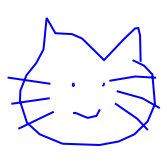

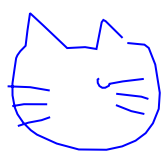

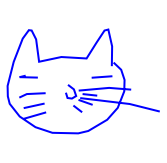

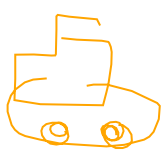

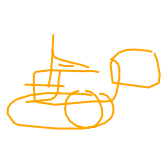

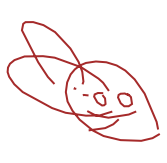

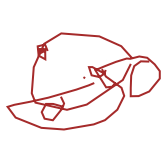

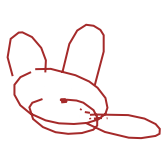

In [211]:
%%time
scene = df_to_scene(df)

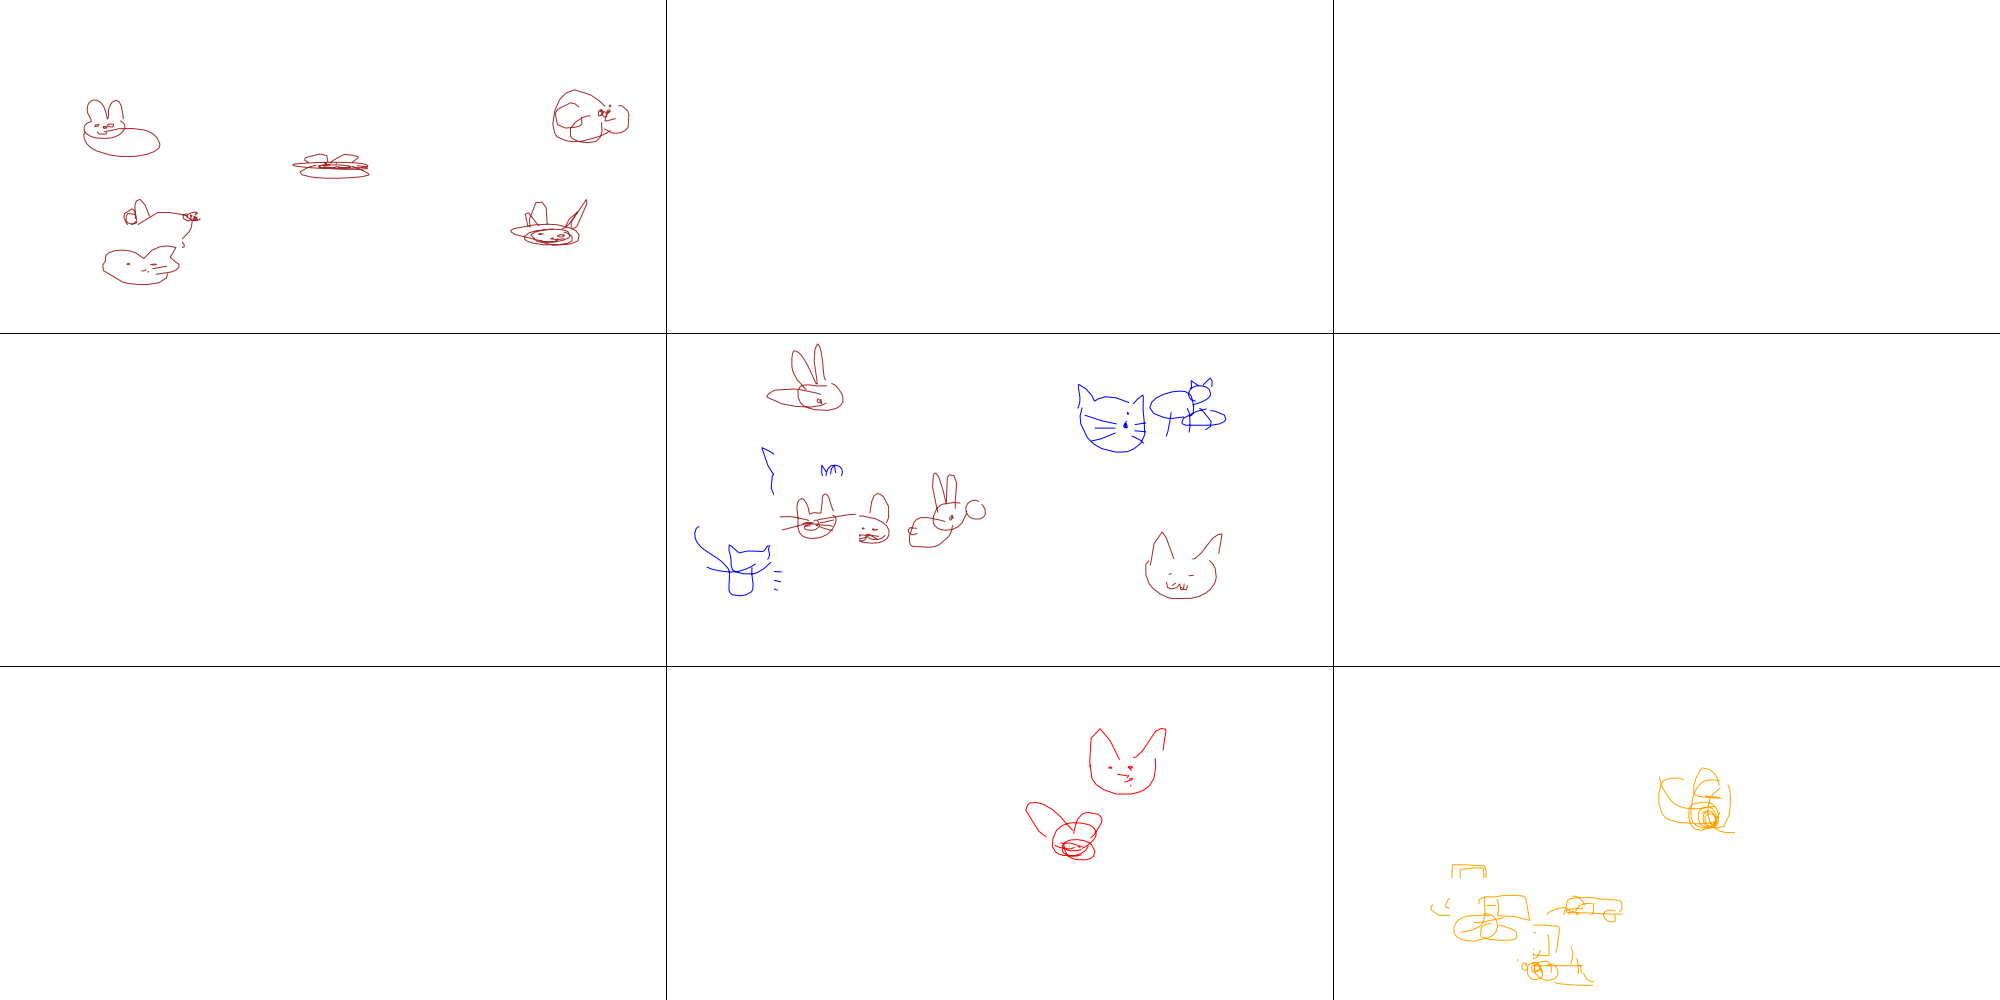

In [212]:
scene

nombre total de dessins : 65652
0,category                  cat
color                    blue
size                    small
num                         6
vertical_position      centre
horizontal_position    middle
Name: 0, dtype: object
Loaded Weights From: ../../raw_data/models/sketch_rnn_cat_weights.78_0.01.hdf5
Loaded Weights From: ../../raw_data/models/sketch_rnn_cat_weights.78_0.01.hdf5
Loaded Weights From: ../../raw_data/models/sketch_rnn_cat_weights.78_0.01.hdf5
Loaded Weights From: ../../raw_data/models/sketch_rnn_cat_weights.78_0.01.hdf5
Loaded Weights From: ../../raw_data/models/sketch_rnn_cat_weights.78_0.01.hdf5
Loaded Weights From: ../../raw_data/models/sketch_rnn_cat_weights.78_0.01.hdf5
1,category               bulldozer
color                     orange
size                       small
num                            5
vertical_position         bottom
horizontal_position        right
Name: 1, dtype: object
Loaded Weights From: ../../raw_data/models/models_sketch_rnn_bulld

/tmp/ipykernel_989/4017094764.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


Loaded Weights From: ../../raw_data/models/sketch_rnn_rabbit_weights.100_0.06.hdf5
4,category               rabbit
color                     red
size                    small
num                         2
vertical_position      bottom
horizontal_position    middle
Name: 4, dtype: object
Loaded Weights From: ../../raw_data/models/sketch_rnn_rabbit_weights.100_0.06.hdf5
Loaded Weights From: ../../raw_data/models/sketch_rnn_rabbit_weights.100_0.06.hdf5
nombre total de dessins : 65652
0,category                  cat
color                    blue
size                    small
num                         6
vertical_position      centre
horizontal_position    middle
Name: 0, dtype: object
Loaded Weights From: ../../raw_data/models/sketch_rnn_cat_weights.78_0.01.hdf5
Loaded Weights From: ../../raw_data/models/sketch_rnn_cat_weights.78_0.01.hdf5
Loaded Weights From: ../../raw_data/models/sketch_rnn_cat_weights.78_0.01.hdf5
Loaded Weights From: ../../raw_data/models/sketch_rnn_cat_weights.78_0.0

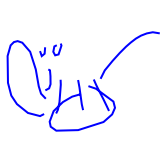

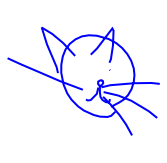

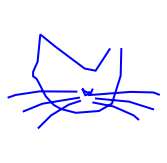

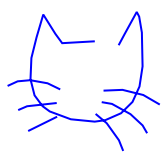

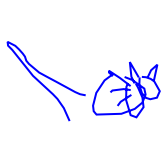

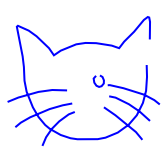

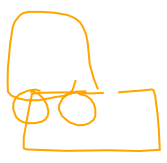

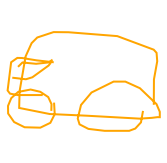

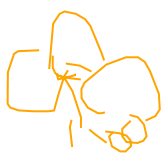

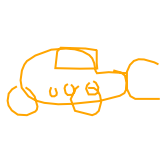

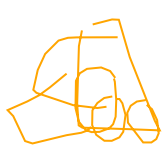

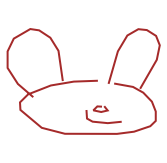

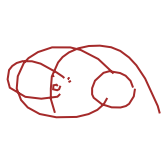

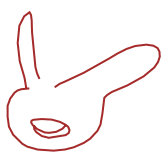

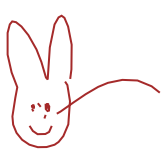

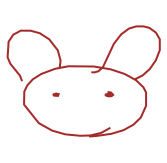

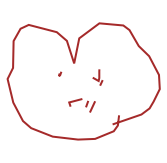

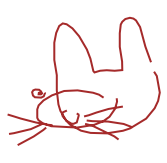

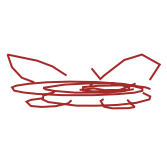

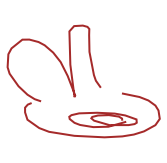

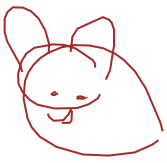

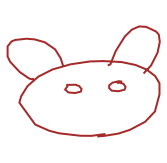

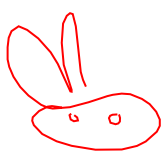

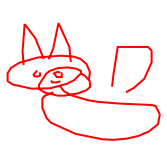

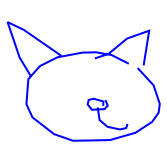

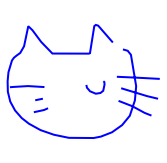

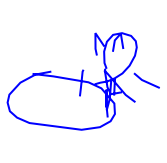

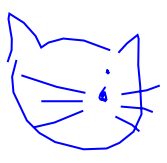

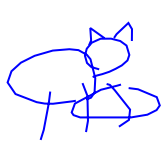

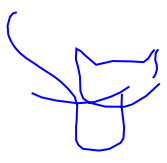

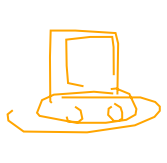

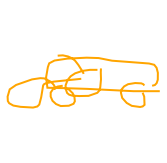

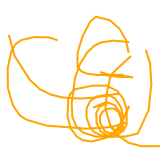

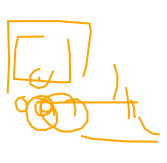

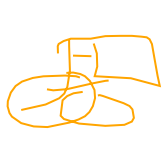

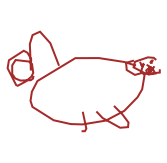

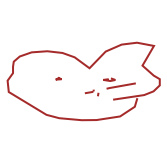

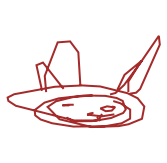

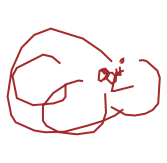

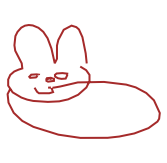

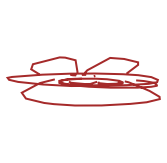

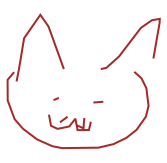

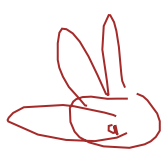

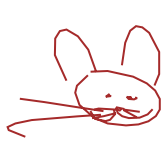

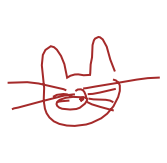

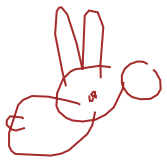

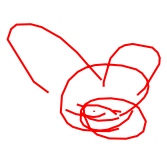

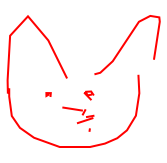

In [162]:
scene1 = df_to_scene(df)
scene2 = df_to_scene(df)

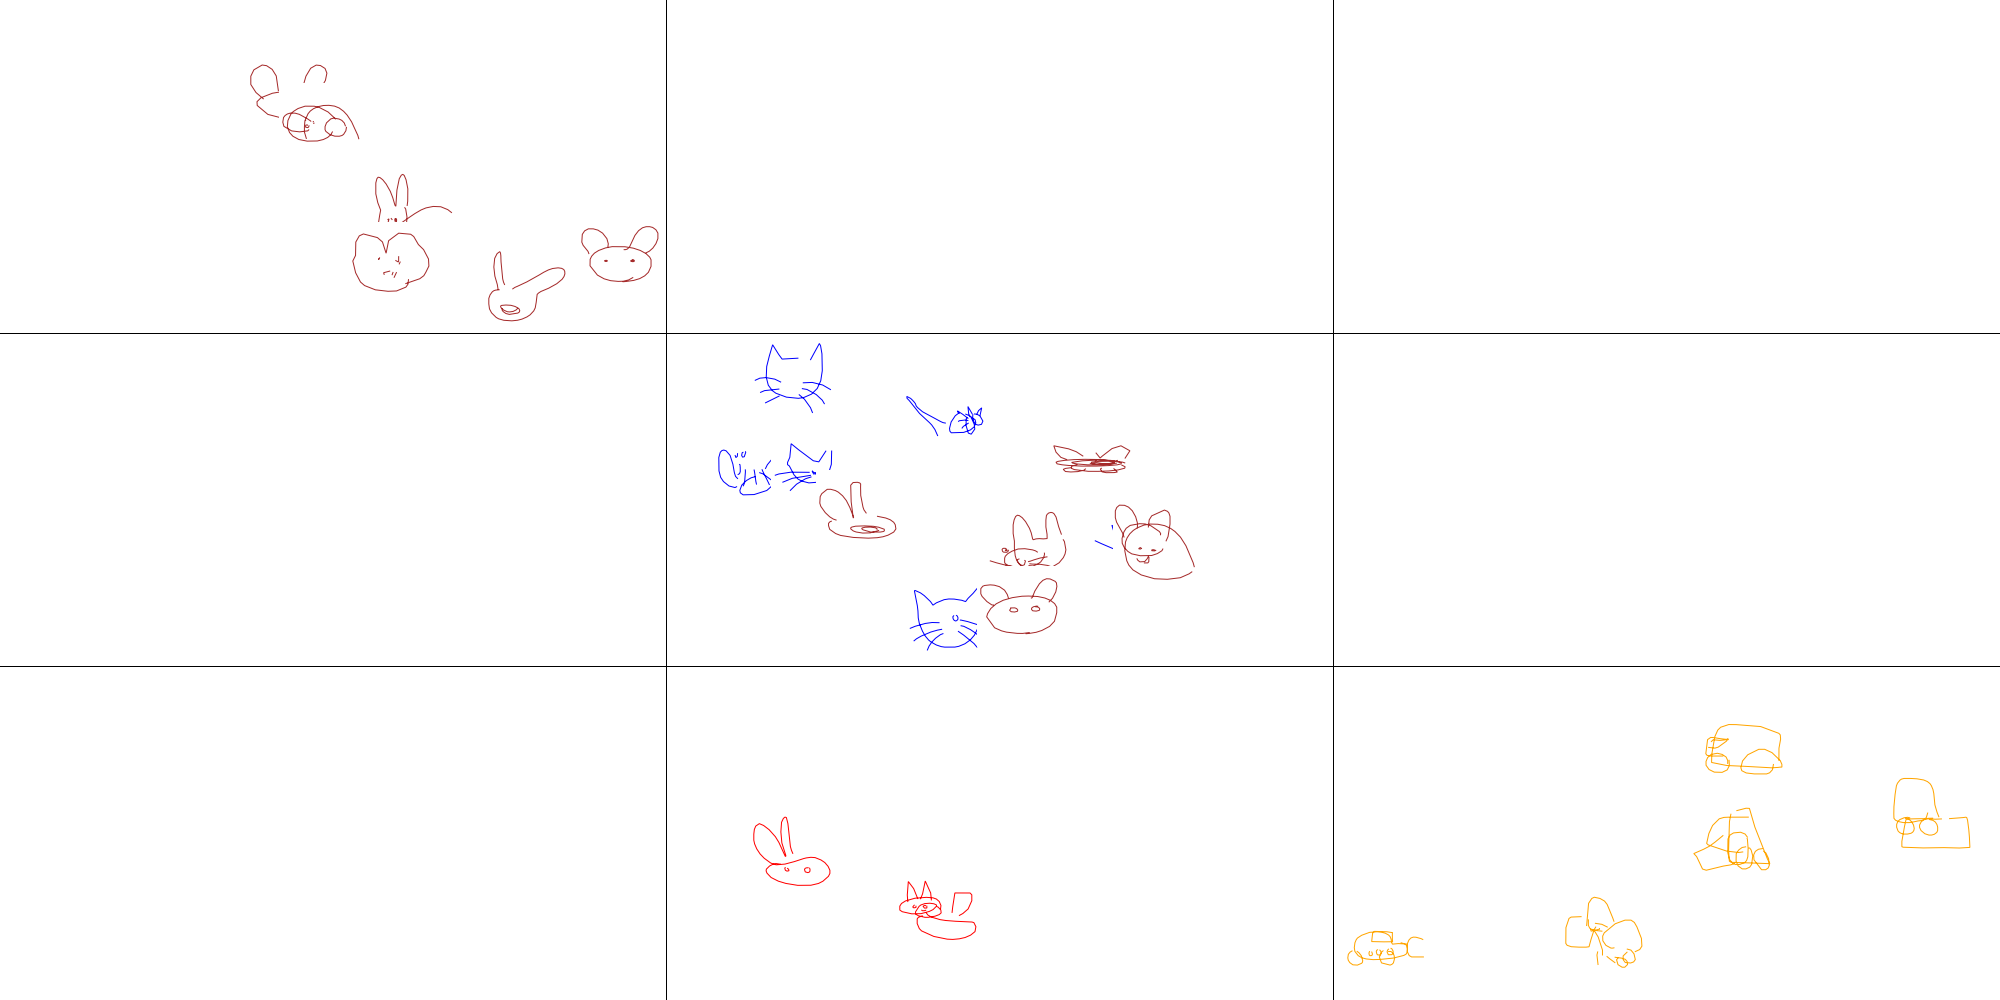

In [163]:
scene1

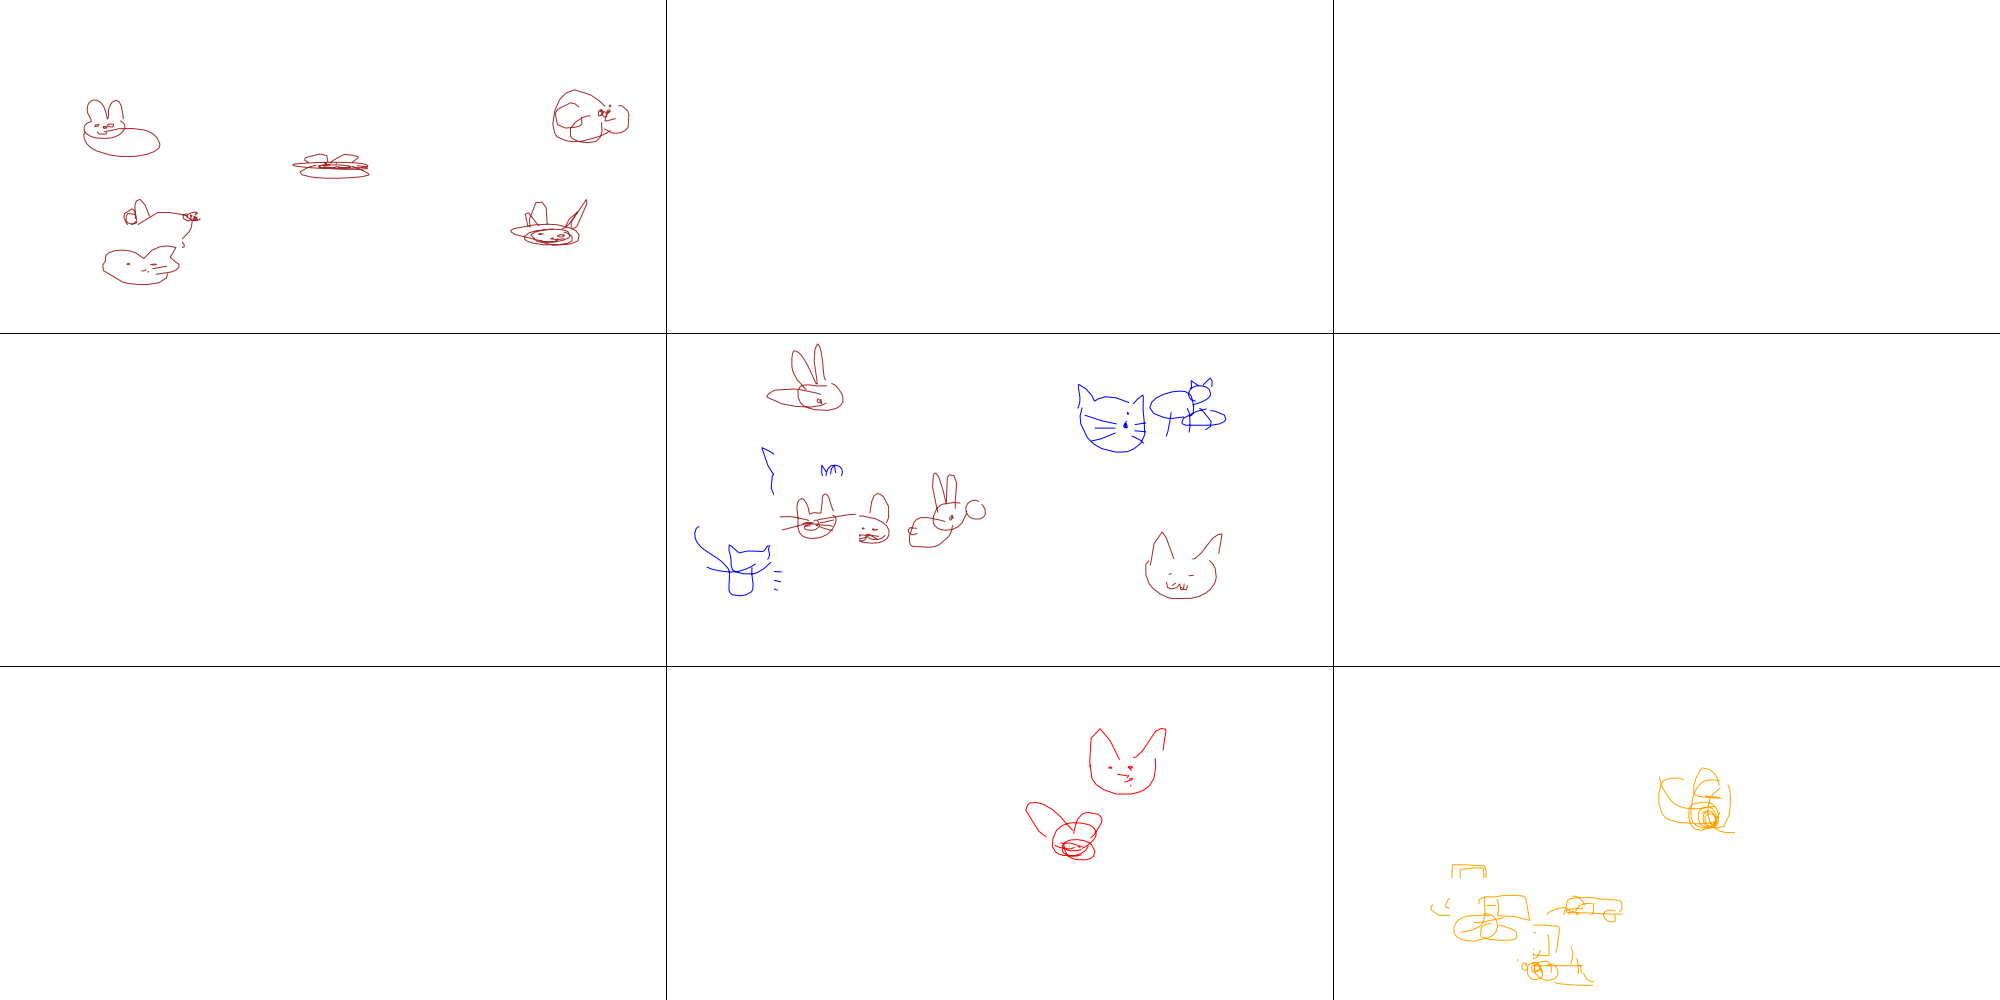

In [164]:
scene2

In [195]:
def construis_la_scene2(list_objects, scene_size = scene_size):
    '''
    list_objects = [[img_obj1, position_obj1], ...]
    '''
    scene = Image.new('RGBA', scene_size)
    for obj in list_objects:
        scene.paste(obj[0], obj[1])
    return scene

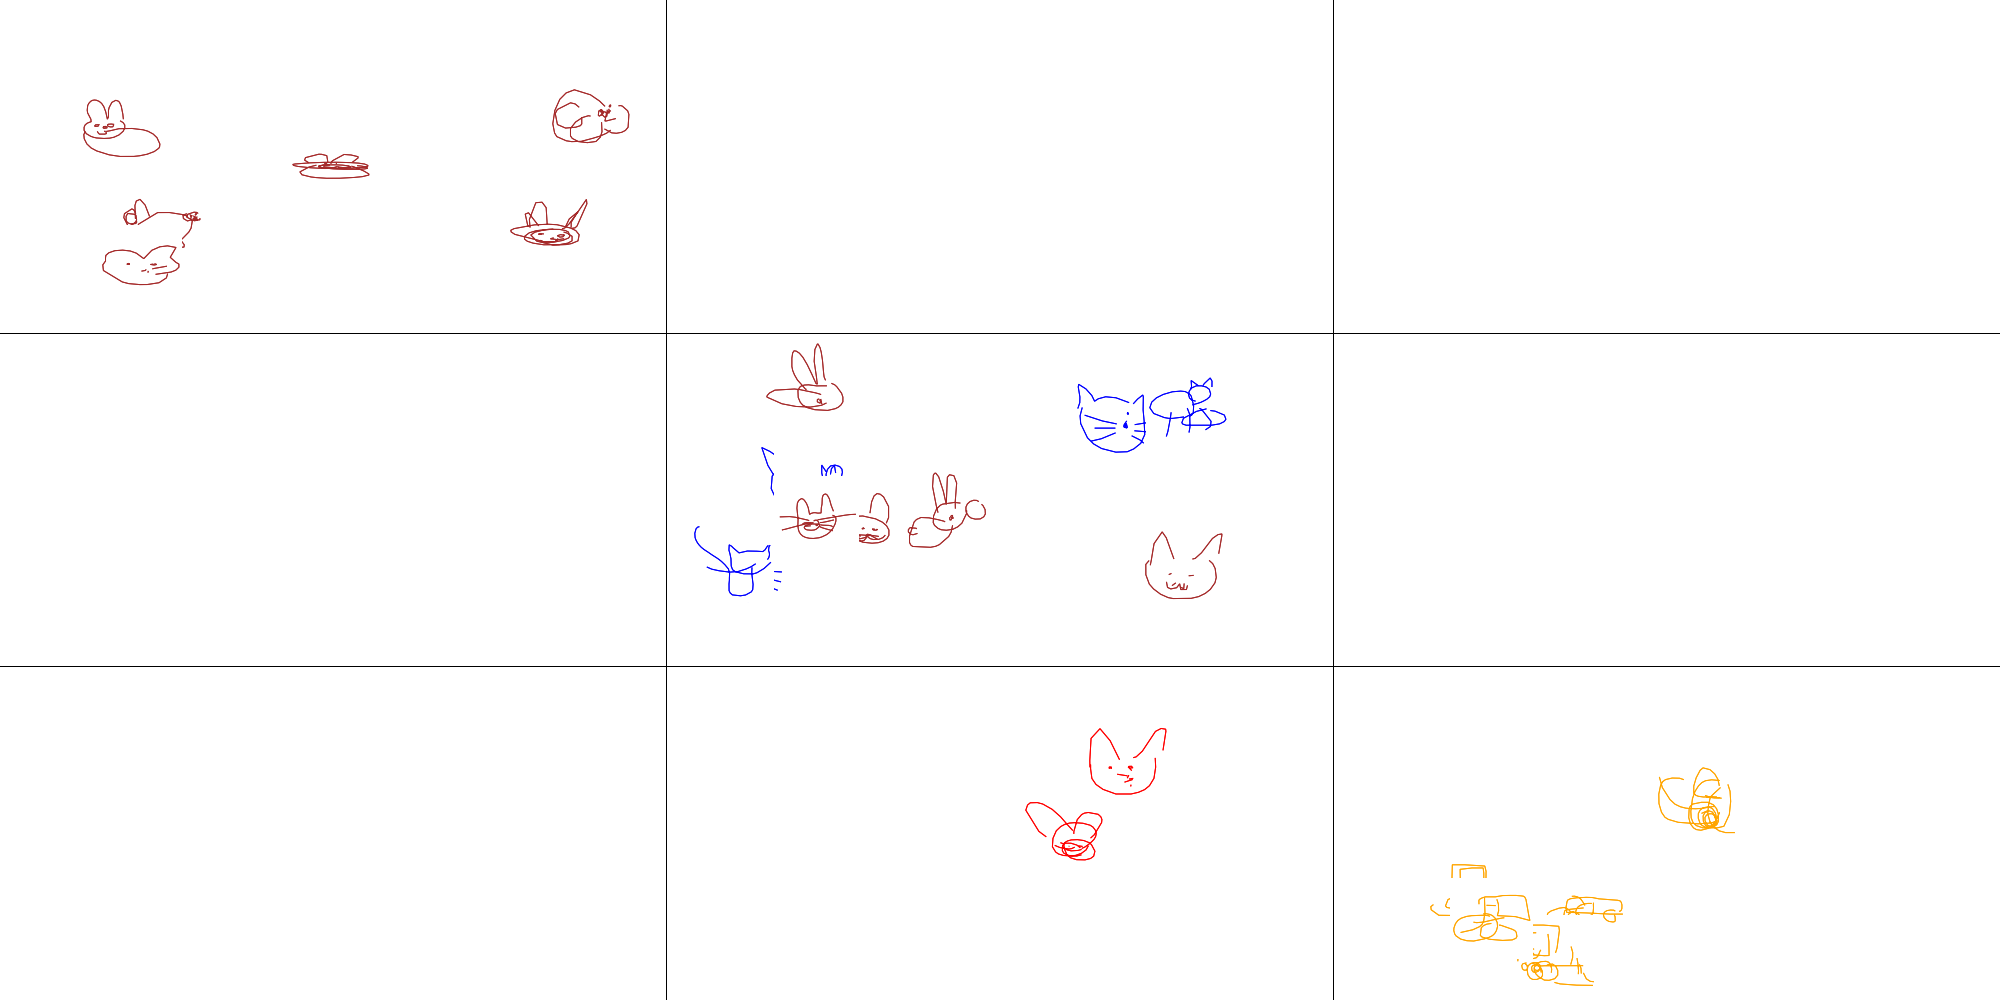

In [202]:
final2 = Image.new("RGBA", scene1.size)
final2 = Image.alpha_composite(final2, scene1)
final2 = Image.alpha_composite(final2, scene2)
final2

In [192]:
scene = scene1.paste(scene2,(0,0),scene2)

AttributeError: 'NoneType' object has no attribute 'show'

In [183]:
type(scene2)

PIL.Image.Image

In [185]:
scene3 = scene2.crop((1, 1, scene2.size[0], scene2.size[1]))

In [186]:
scene = scene1.paste(scene3)

In [187]:
type(scene)

NoneType

In [179]:
scene.save('scene.png')

AttributeError: 'NoneType' object has no attribute 'save'

In [178]:
!pwd

/home/romain/code/Tchook115/ouatai/notebooks
